In [1]:
import numpy as np
from optparse import OptionParser
import pickle
import re
import scipy.fftpack as fftp
import os
import imp
import sys
import glob
import matplotlib.pyplot as plt
import scipy.interpolate as intp
from matplotlib import cm
from scipy.signal import hilbert
from scipy.signal import resample

sys.path.insert(1,'scripts/')
import fluence as fluence
import process_sim as sim
import process_func as prf


sys.path.insert(1,'/vol/astro7/lofar/kmulrey/interpolation_fourier/')
import interpolation_Fourier as interpF

## This notebook is an example for how to find and plot all relavent information for a given LOFAR event

In [14]:
event=87931183

In [15]:
# for each event that has been processed for "antenna specific simulations", a summary file exists
# otherwise, this can be generated and found at "/vol/astro7/lofar/vhecr/event_information" (this still needs to be populated)

summary_file=open('/vol/astro7/lofar/vhecr/event_information/summary_{0}.p'.format(str(event)),'rb')

event_info = pickle.load(summary_file)
summary_file.close()
print(event_info)


{'event': '87931183', 'energy_scale_factor': 1.1031883054458476, 'zenith': 0.42870481619665457, 'azimuth': 8.66456862897986, 'coreX': 52.89149390010833, 'coreY': -164.1285540751677, 'xmaxreco': 709.7410010031913, 'xmaxbest': 719.89, 'best_runnr': '000326', 'best_event_directory': '/vol/astro7/lofar/sim/pipeline/events/87931183/2/coreas/proton/', 'best_steering': '/vol/astro7/lofar/sim/pipeline/events/87931183/2/coreas/proton/steering/RUN000326.inp', 'data_file': '/vol/astro7/lofar/sim/pipeline/run/data/dbrev87931183.dat', 'stations': array([b'CS002', b'CS004', b'CS005', b'CS006', b'CS007'], dtype='|S5')}


In [16]:
#this is the simulation from the most recent iteration that best matches the data
datadir=event_info['best_event_directory']
fileno=event_info['best_runnr']
print(datadir)

/vol/astro7/lofar/sim/pipeline/events/87931183/2/coreas/proton/


In [17]:
# process coreas simulations, and return electric field, voltage, fluence, antenna positions
sim_info=sim.ProcessData(datadir,fileno,30,80) # 30-80 is the frequency range for bandpass filter


In [18]:
# process data files, and return electric field, voltage, fluence, antenna positions
data_file=open(event_info['data_file'],'rb')
(core_x, core_y, station_name, antenna_ids, positions, dist, x_err, signal, dpower11, dpower21, dpower41, rms, noisepower, pulse_delay_fit_residual, data_time, lora_x, lora_y, lora_dens, data_azimuth, data_zenith, lora_zenith)=pickle.load(data_file, encoding='latin1')
data_file.close()

In [19]:
stations= np.unique(station_name)

In [20]:
# antenna positions in the vxB, vxvxB reference frame
antUVW=prf.GetUVW(sim_info['antenna_position'], 0, 0, 7.6,sim_info['zenith'], sim_info['azimuth'],Binc=1.1837)
LOFARantUVW=prf.GetUVW( positions, event_info['coreX'], event_info['coreY'], 7.6,sim_info['zenith'], sim_info['azimuth'],Binc=1.1837)


# antenna positions in the vxB, vxvxB reference frame
SIMantLOFAR=prf.reverse_GetUVW(sim_info['antenna_position'], event_info['coreX'], event_info['coreY'],7.6, event_info['zenith'],  event_info['azimuth'],Binc=1.1837)




In [21]:
# Get instance of interpolator, using given values for (x, y)
rbf = intp.Rbf(antUVW.T[0], antUVW.T[1], sim_info['fluence']*event_info['energy_scale_factor']**2,smooth =0,function='quintic')
rbf_voltage = intp.Rbf(antUVW.T[0], antUVW.T[1], (sim_info['integrated_power'].T[0]+sim_info['integrated_power'].T[1])*event_info['energy_scale_factor']**2,smooth =0,function='quintic')
#rbf_voltage_ground = intp.Rbf(SIMantLOFAR.T[0], SIMantLOFAR.T[1], (sim_info['integrated_power'].T[0]+sim_info['integrated_power'].T[1])*event_info['energy_scale_factor']**2,smooth =0,function='quintic')
rbf_voltage_ground = intp.Rbf(sim_info['antenna_position'].T[0]+event_info['coreX'], sim_info['antenna_position'].T[1]+event_info['coreY'], (sim_info['integrated_power'].T[0]+sim_info['integrated_power'].T[1])*event_info['energy_scale_factor']**2,smooth =0,function='quintic')

# need to move to fourier_interpolator, but it sometimes returns an error
#fourier_interpolator = interpF.interp2d_fourier(antUVW.T[0], antUVW.T[1], sim_info['fluence']*event_info['energy_scale_factor']**2)



In [22]:
# print event information
print(event_info.keys())

print('zenith angle:   {0:.2f}'.format(180/np.pi*event_info['zenith']))
print('azimuth angle:   {0:.2f}'.format(180/np.pi*event_info['azimuth']-360))
print('xmax:   {0:.2f}'.format(event_info['xmaxreco']))
print('log10(energy):   {0:.2f}'.format(9+np.log10(sim_info['energy']*event_info['energy_scale_factor'])))
print('core:   ({0:.2f}, {1:.2f})'.format(event_info['coreX'],event_info['coreY']))
print('stations: {0}'.format(stations))

dict_keys(['event', 'energy_scale_factor', 'zenith', 'azimuth', 'coreX', 'coreY', 'xmaxreco', 'xmaxbest', 'best_runnr', 'best_event_directory', 'best_steering', 'data_file', 'stations'])
zenith angle:   24.56
azimuth angle:   136.44
xmax:   709.74
log10(energy):   17.40
core:   (52.89, -164.13)
stations: [b'CS002' b'CS004' b'CS005' b'CS006' b'CS007']


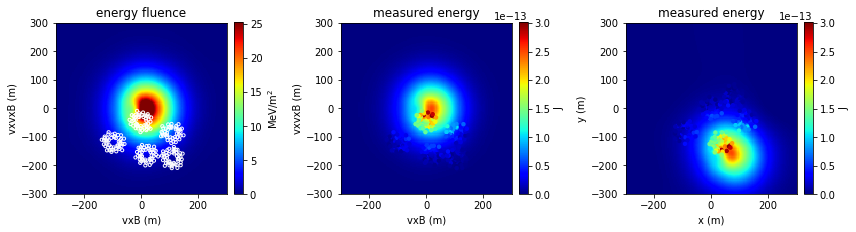

In [23]:
# plotting routine for footprint
dist_scale=300
ti = np.linspace(-dist_scale, dist_scale, 150)
XI, YI = np.meshgrid(ti, ti)
ZI = rbf(XI, YI)
ZI_voltage = rbf_voltage(XI, YI)
ZI_voltage_ground = rbf_voltage_ground(XI, YI)


maxV=np.max([np.max(sim_info['integrated_power'].T[0]+sim_info['integrated_power'].T[1])*event_info['energy_scale_factor']**2,np.max(dpower11.T[0]+dpower11.T[1])*event_info['energy_scale_factor']**2])

fig = plt.figure(figsize=(12,5))
ax1=plt.subplot(1,3,1,aspect=1)
ax2=plt.subplot(1,3,2,aspect=1)
ax3=plt.subplot(1,3,3,aspect=1)

pc1=ax1.pcolor(XI, YI, ZI,vmax=np.max(sim_info['fluence']), vmin=0,cmap=cm.jet)
pc2=ax2.pcolor(XI, YI, ZI_voltage,vmax=maxV, vmin=0,cmap=cm.jet)
pc3=ax3.pcolor(XI, YI, ZI_voltage_ground,vmax=maxV, vmin=0,cmap=cm.jet)

ax1.scatter(LOFARantUVW.T[0],LOFARantUVW.T[1],10,facecolors='none', edgecolors='white')


ax2.scatter(LOFARantUVW.T[0],LOFARantUVW.T[1],20,c=(dpower11.T[0]+dpower11.T[1])*event_info['energy_scale_factor']**2,vmax=maxV, vmin=0,edgecolors='none',cmap=cm.jet)
ax3.scatter(positions.T[0],positions.T[1],20,c=(dpower11.T[0]+dpower11.T[1])*event_info['energy_scale_factor']**2,vmax=maxV, vmin=0,edgecolors='none',cmap=cm.jet)


cbar1=fig.colorbar(pc1, ax=ax1,fraction=0.046, pad=0.04)
cbar2=fig.colorbar(pc2, ax=ax2,fraction=0.046, pad=0.04)
cbar3=fig.colorbar(pc3, ax=ax3,fraction=0.046, pad=0.04)

cbar1.set_label('MeV/m$^2$', rotation=90)
cbar2.set_label('J', rotation=90)
cbar3.set_label('J', rotation=90)


ax1.set_title('energy fluence')
ax2.set_title('measured energy') # "measured energy" is what we call the integrated voltage in the antenna
ax3.set_title('measured energy')

ax1.set_xlabel('vxB (m)')
ax1.set_ylabel('vxvxB (m)')

ax2.set_xlabel('vxB (m)')
ax2.set_ylabel('vxvxB (m)')

ax3.set_xlabel('x (m)')
ax3.set_ylabel('y (m)')

fig.tight_layout()
plt.show()


In [24]:
# see how many antennas have data per station and make sure it matches what's in the data files

for s in np.arange(len(stations)):
    indices=np.where(station_name==stations[s])[0]
    print('station {0} has {1} antennas'.format(stations[s].decode(),len(indices)))
    dat_file='/vol/astro3/lofar/vhecr/lora_triggered/results/{0}/calibrated_pulse_block-{0}-{1}.npy'.format(str(event),stations[s].decode())
    data = np.load(dat_file)
    nantennas_data=int(len(data)/2)
    if nantennas_data!=len(indices):
        print('mismatch between data and what is saved after processing')
    

station CS002 has 46 antennas
station CS004 has 46 antennas
station CS005 has 47 antennas
station CS006 has 43 antennas
station CS007 has 46 antennas


47


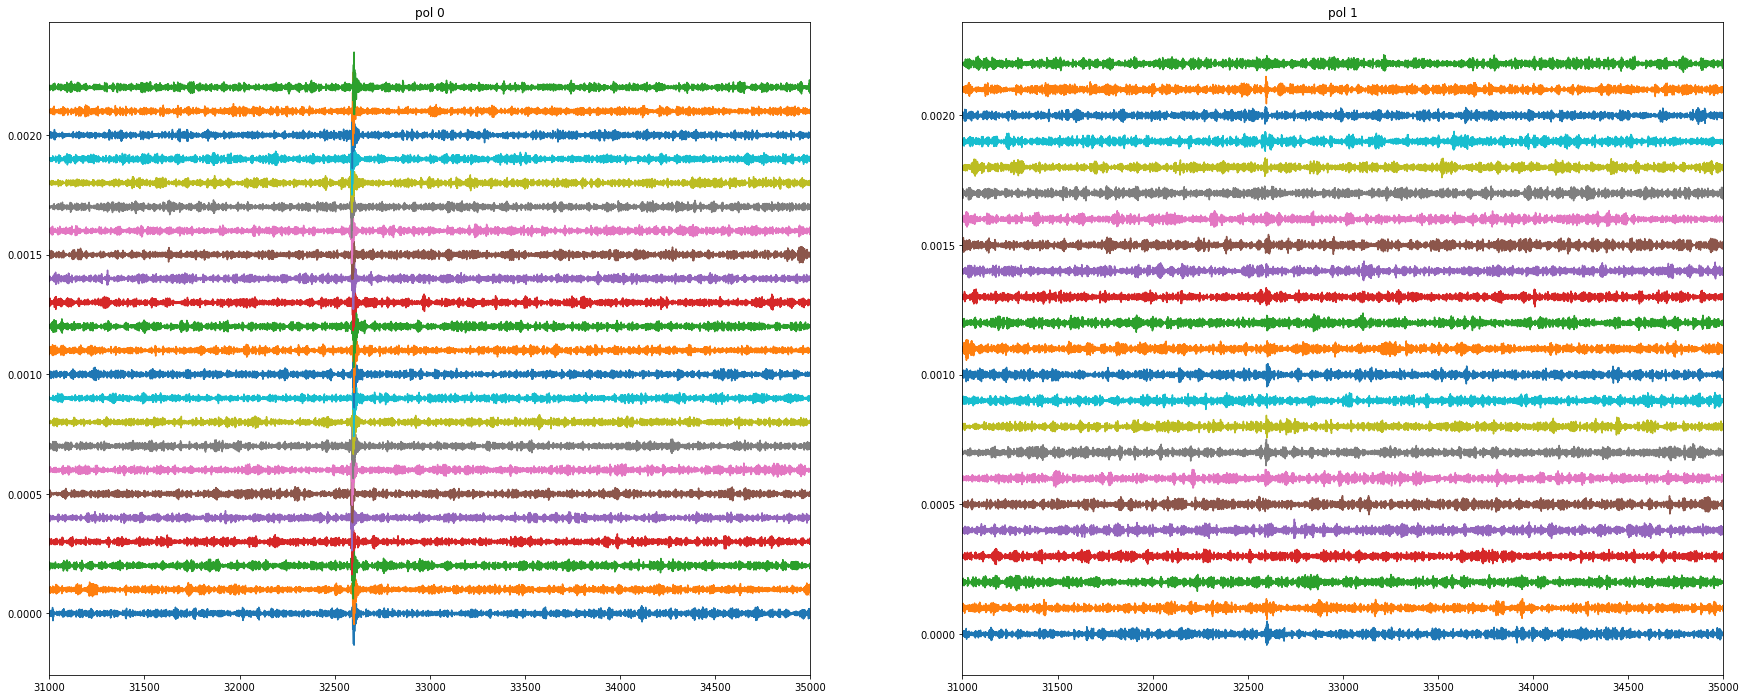

In [27]:
# plot data from one station
dat_file='/vol/astro3/lofar/vhecr/lora_triggered/results/{0}/calibrated_pulse_block-{0}-{1}.npy'.format(str(event),'CS005')
data = np.load(dat_file)

offset=10e-5

fig = plt.figure(figsize=(30,12))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)


ax1.set_title('pol 0')
ax2.set_title('pol 1')

#ax2 = fig.add_subplot(3,1,2)
#ax3 = fig.add_subplot(3,1,3)
nAnt=int(len(data)/2)
print(nAnt)

# just plot a selection so it's readable
for i in np.arange(int(nAnt/2)):
    ax1.plot(data[i*2]+i*offset)
    ax2.plot(data[i*2+1]+i*offset)

ax1.set_xlim(31000,35000)
ax2.set_xlim(31000,35000)

plt.show()

